In [1]:
import librosa
import numpy as np

def load_audio(file_path, sr=16000, mono=True):
    """
    Loads an audio file, resamples it to the desired sample rate, and converts to mono if needed.
    """
    audio, _ = librosa.load(file_path, sr=sr, mono=mono)
    return audio

def split_into_clips(audio, clip_length_sec=10, sr=16000):
    """
    Splits audio into fixed-length clips. Pads the last clip if it's shorter than the desired length.
    """
    clip_length = clip_length_sec * sr  # Length of each clip in samples
    num_clips = int(np.ceil(len(audio) / clip_length))  # Number of clips
    clips = []

    for i in range(num_clips):
        start = i * clip_length
        end = start + clip_length
        clip = audio[start:end]
        
        # If the last clip is shorter than the clip length, pad it with zeros
        if len(clip) < clip_length:
            clip = np.pad(clip, (0, clip_length - len(clip)), 'constant')

        clips.append(clip)
    
    return np.array(clips)

def normalize_audio(audio):
    """
    Normalizes the audio to the range [-1, 1].
    """
    return audio / np.max(np.abs(audio))

def audio_to_spectrogram(audio, n_fft=1024, hop_length=512):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)  # Magnitude spectrogram
    return spectrogram

def remove_invalid_values(audio):
    """
    Removes non-finite values (NaN, inf) from the audio by replacing them with zero.
    """
    # Replace NaN or inf values with 0
    audio = np.nan_to_num(audio, nan=0.0, posinf=0.0, neginf=0.0)
    return audio


In [3]:

# Example usage:
noisy_audio = load_audio(r"noise audio\noise_3.wav", sr=16000, mono=True)
clean_audio = load_audio(r"audio_denoise.com\denoise_3.wav", sr=16000, mono=True)

noisy_clips = split_into_clips(noisy_audio, clip_length_sec=10, sr=16000)
clean_clips = split_into_clips(clean_audio, clip_length_sec=10, sr=16000)

noisy_clips = [normalize_audio(clip) for clip in noisy_clips]
clean_clips = [normalize_audio(clip) for clip in clean_clips]


C:\Users\Siddhartha Devan V\AppData\Local\Temp\ipykernel_21188\183116577.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=sr, mono=mono)


FileNotFoundError: [Errno 2] No such file or directory: 'noise audio\\noise_3.wav'

In [5]:
print(len(noisy_clips))

5


In [7]:
for i in noisy_clips:
    print(len(i))
for i in clean_clips:
    print(len(i))

160000
160000
160000
160000
160000
160000
160000
160000
160000
160000


In [8]:
X = np.array(noisy_clips).reshape(-1, 160000, 1)  # For 16 kHz, 10 sec = 160000 samples
y = np.array(clean_clips).reshape(-1, 160000, 1)

In [14]:
noisy_clips = [remove_invalid_values(clip) for clip in noisy_clips]
clean_clips = [remove_invalid_values(clip) for clip in clean_clips]

noisy_spectrograms = [audio_to_spectrogram(clip) for clip in noisy_clips]
clean_spectrograms = [audio_to_spectrogram(clip) for clip in clean_clips]

# # Reshape for Conv2D models (Height, Width, Channels)
# X = np.array(noisy_spectrograms).reshape(-1, height, width, 1)
# y = np.array(clean_spectrograms).reshape(-1, height, width, 1)

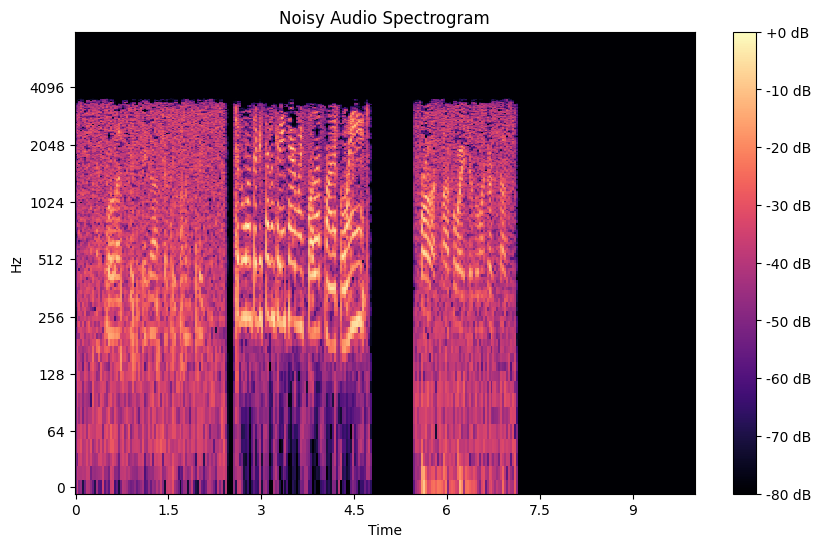

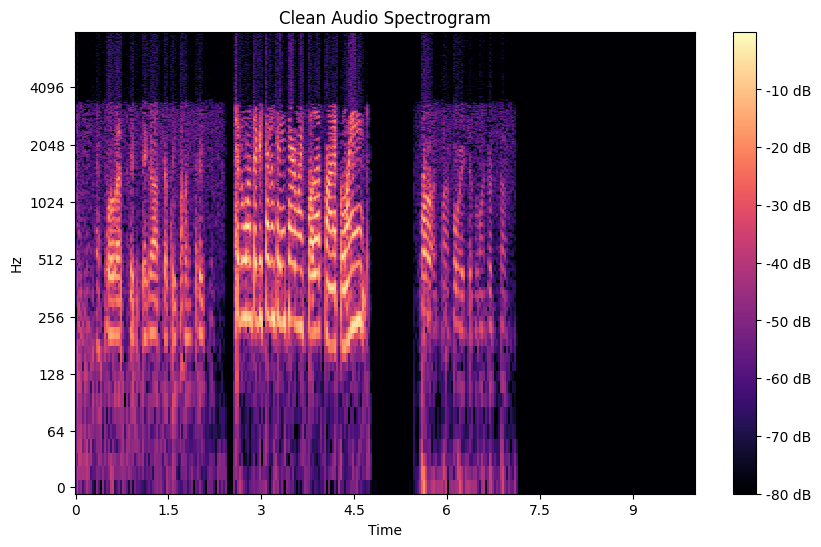

In [15]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spectrogram(spectrogram, sr=16000, hop_length=512, title="Spectrogram"):
    """
    Visualizes a spectrogram using librosa and matplotlib.
    """
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                             sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Example usage: visualize one of your noisy or clean spectrograms
plot_spectrogram(noisy_spectrograms[0], sr=16000, hop_length=512, title="Noisy Audio Spectrogram")
plot_spectrogram(clean_spectrograms[0], sr=16000, hop_length=512, title="Clean Audio Spectrogram")


In [ ]:
import librosa
import librosa.display
import os
import soundfile as sf
import pickle

def save_stft(audio, sr, n_fft=1024, hop_length=512):
    """
    Compute and return the STFT of the audio.
    """
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    return spectrogram

def split_save_audio_and_stft(audio, sr, clip_length, raw_save_dir, stft_save_dir, base_filename, start_index, n_fft=1024, hop_length=512):
    """
    Split the audio into 10-second clips, save the raw audio using librosa or soundfile, and compute & save the STFT.
    """
    num_clips = len(audio) // clip_length
    for i in range(num_clips):
        # Get 10-second audio clip
        clip = audio[i * clip_length: (i + 1) * clip_length]
        
        # Save raw audio using librosa or soundfile
        raw_filename = f"{base_filename}_clip_{start_index + i}.wav"
        sf.write(os.path.join(raw_save_dir, raw_filename), clip, sr)  # `librosa` could also be used to save as wav
        
        # Compute and save STFT using pickle (or optionally .npy format)
        stft = save_stft(clip, sr, n_fft, hop_length)
        stft_filename = f"{base_filename}_clip_{start_index + i}.pkl"
        with open(os.path.join(stft_save_dir, stft_filename), 'wb') as f:
            pickle.dump(stft, f)



In [2]:
s = 'uoawefogh'

print(s[:-4])

uoawe


In [ ]:
import tensorflow as tf
import librosa
import numpy as np
import os

def load_audio(file_path, sr=16000):
    """
    Loads an audio file, resamples it to the desired sample rate.
    """
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def preprocess_audio(audio, clip_length=160000):
    """
    Pads or trims audio to the desired clip length (10 seconds at 16 kHz = 160000 samples).
    """
    if len(audio) < clip_length:
        audio = np.pad(audio, (0, clip_length - len(audio)), 'constant')
    else:
        audio = audio[:clip_length]
    return audio

def audio_generator(noisy_dir, clean_dir, batch_size=32, sr=16000, clip_length=160000):
    """
    Generator function to load and preprocess audio files in batches.
    """
    noisy_files = sorted(os.listdir(noisy_dir))
    clean_files = sorted(os.listdir(clean_dir))
    
    while True:
        # Shuffle file list to ensure randomness
        idxs = np.arange(len(noisy_files))
        np.random.shuffle(idxs)
        
        for start in range(0, len(noisy_files), batch_size):
            batch_noisy = []
            batch_clean = []
            
            for i in idxs[start:start + batch_size]:
                noisy_file = os.path.join(noisy_dir, noisy_files[i])
                clean_file = os.path.join(clean_dir, clean_files[i])

                # Load and preprocess audio
                noisy_audio = load_audio(noisy_file, sr)
                clean_audio = load_audio(clean_file, sr)
                
                noisy_audio = preprocess_audio(noisy_audio, clip_length)
                clean_audio = preprocess_audio(clean_audio, clip_length)
                
                batch_noisy.append(noisy_audio)
                batch_clean.append(clean_audio)
            
            yield (np.array(batch_noisy), np.array(batch_clean))

# Create a tf.data.Dataset from the generator
def create_tf_dataset(noisy_dir, clean_dir, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: audio_generator(noisy_dir, clean_dir, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, 160000), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 160000), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Usage
noisy_dir = 'path_to_noisy_clips'
clean_dir = 'path_to_clean_clips'

train_dataset = create_tf_dataset(noisy_dir, clean_dir, batch_size=32)
